# Imports

In [1]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt

In [2]:
class ChangedFile:
    def __init__(self, mutant_id = -1, modified_file_path = '', line_number_changed = -1, previous_line = '', current_line = ''):
        self.modified_file_path = modified_file_path
        self.line_number_changed = line_number_changed
        self.previous_line = previous_line
        self.current_line = current_line
        self.mutant_id = mutant_id
    def __str__(self):
        return "Mutant ID:" + mutant_id + "\nModified file: "+ self.modified_file_path + "\n  Line number: " + str(self.line_number_changed) + "\nPrevious Line: " + self.previous_line + " Current line: " + self.current_line

In [3]:
def generate_repo_diff_data(repo: Repo, mutant_id=-1):
    current_diff = repo.index.diff(None)
    diff = repo.git.diff(repo.head, None)
    patchset = PatchSet(diff)
    
    print(patchset[0].target_file)
    modified_file_path = patchset[0].target_file[2:] # Remove b/ from the path
    changed_sourcecode_line = patchset[0][0].source_start
    previous_line = ''
    change_to_line = ''
    for line in patchset[0][0]:
        if line.is_added:
            changed_to_line = str(line)[2:]
        if line.is_removed:
            previous_line = str(line)[2:]
    
    return ChangedFile(mutant_id, modified_file_path, changed_sourcecode_line, previous_line, changed_to_line)

#print(analyze_change_in_working_directory(repo).__dict__)

In [4]:
def generate_test_data(mutant_id=-1):
    with open('repos/flask/report.json') as json_file:
        data = json.load(json_file)["report"]
#         print(json.dumps(data, indent=2))
        test_runs = []
        for test in data["tests"]:
            outcome = True
            if test["outcome"] == "failed":
                outcome = False
            test_runs.append({'test_id': test["run_index"], 'mutant_id': mutant_id, 'outcome': outcome})
        return test_runs
        

In [5]:
!cd repos/flask/ && pytest --json=report.json --timeout=300

============================= test session starts ==============================
platform linux -- Python 3.8.1, pytest-5.4.2, py-1.8.1, pluggy-0.13.1
rootdir: /mnt/brick/home/dmeier/CRM2020/repos/flask, inifile: setup.cfg, testpaths: tests
plugins: json-report-1.2.1, json-0.4.0, metadata-1.9.0
collected 468 items                                                            

tests/test_appctx.py ..............                                      [  2%]
tests/test_basic.py .................................................... [ 14%]
......................................................................   [ 29%]
tests/test_blueprints.py ............................................... [ 39%]
.                                                                        [ 39%]
tests/test_cli.py ..^C


In [6]:
mutants = pd.DataFrame(columns=['mutant_id','modified_file_path','line_number_changed','previous_line', 'current_line'])
mutants
test_runs = pd.DataFrame(columns=['test_id', 'mutant_id', 'outcome'])

"failed" == "failed"

True

In [7]:
def analyze_mutant(*,mutant_id):
    repo = Repo("repos/flask")
    assert not repo.bare
    !echo Switching to Mutant $mutant_id
    !. crm2020_python3.8/bin/activate && cd repos/flask/ && mutmut apply $mutant_id && pytest --json=report.json > /dev/null
    changed_file = generate_repo_diff_data(repo= repo, mutant_id=mutant_id)
    tests = generate_test_data(mutant_id=mutant_id)
    
    # Cleanup logic:
    !cd repos/flask/ && git checkout .
    !rm repos/flask/report.json
    
    return {"changed_file": changed_file, "tests": tests}
    
# analyze_mutant(mutant_id=1)

In [ ]:
tests = pd.DataFrame()
mutants = pd.DataFrame()

for mutant_id in range(1, 2091, 1):
    try:
        result = analyze_mutant(mutant_id=mutant_id)
        tests = tests.append(result["tests"], ignore_index=True)
        mutants = mutants.append(result["changed_file"].__dict__, ignore_index=True)
        print("Tests length: " + str(len(tests)))
    except:
        print("Unexpected error:", sys.exc_info()[0])
        print("Resetting the repo and then testing the next mutant")
        !cd repos/flask/ && git checkout .


In [12]:
len(tests)


937872

In [ ]:
mutants_and_tests = mutants.set_index('mutant_id').join(tests.set_index('mutant_id'))
# mutants_and_tests.to_pickle('flask_dataset_every_mutant_with_checkout_on_failure.pkl')

In [ ]:
mutants_and_tests.groupby(['test_id','outcome']).count()['current_line']


In [120]:
# Covariance Matrix 
# mutants_and_tests = pd.read_pickle('flask_dataset_every_mutant_with_checkout_on_failure.pkl')
mutants_and_tests.reset_index()
mutants_and_tests["outcome"] = mutants_and_tests["outcome"].astype('bool')
mutants_and_tests["outcome"]

mutant_id
1.0       True
1.0       True
1.0       True
1.0       True
1.0       True
          ... 
2090.0    True
2090.0    True
2090.0    True
2090.0    True
2090.0    True
Name: outcome, Length: 937873, dtype: bool

In [121]:
pivot = mutants_and_tests.pivot(columns='test_id', values='outcome')
pivot.drop(pivot.columns[0], axis=1, inplace=True)
print(pivot.columns)

Float64Index([  0.0,   1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,
                9.0,
              ...
              458.0, 459.0, 460.0, 461.0, 462.0, 463.0, 464.0, 465.0, 466.0,
              467.0],
             dtype='float64', name='test_id', length=468)


In [129]:
pivot = pivot.astype('bool')

test_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,458.0,459.0,460.0,461.0,462.0,463.0,464.0,465.0,466.0,467.0
test_id,,,,,,,,,,,,,,,,,,,,,
0.0,0.017642,0.007832,0.001470,0.006849,0.006057,0.006317,0.006317,0.006317,0.008280,0.006428,...,0.007958,0.008236,0.008245,0.007859,0.008263,0.008254,0.007806,0.008236,0.008227,0.008110
1.0,0.007832,0.008411,0.000985,0.007185,0.006783,0.006906,0.006906,0.006906,0.006918,0.004990,...,0.006766,0.006897,0.006901,0.006719,0.006910,0.006905,0.006694,0.006897,0.006893,0.006838
2.0,0.001470,0.000985,0.001495,0.000945,0.000463,0.000485,0.000485,0.000485,0.000898,0.000910,...,0.000871,0.000894,0.000895,0.000863,0.000896,0.000896,0.000858,0.000894,0.000893,0.000884
3.0,0.006849,0.007185,0.000945,0.034175,0.023104,0.006650,0.006650,0.006650,0.031065,0.027855,...,0.029930,0.029979,0.031494,0.020754,0.030531,0.030513,0.029630,0.030478,0.030460,0.030231
4.0,0.006057,0.006783,0.000463,0.023104,0.023379,0.006759,0.006759,0.006759,0.021852,0.018550,...,0.019925,0.019797,0.021306,0.010812,0.020331,0.020319,0.019722,0.020296,0.020284,0.020128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463.0,0.008254,0.006905,0.000896,0.030513,0.020319,0.006338,0.006338,0.006338,0.047826,0.043881,...,0.061070,0.055640,0.058668,0.042731,0.061231,0.063692,0.058993,0.062127,0.062592,0.061650
464.0,0.007806,0.006694,0.000858,0.029630,0.019722,0.006102,0.006102,0.006102,0.048654,0.044907,...,0.073425,0.059898,0.056951,0.056945,0.057543,0.058993,0.084610,0.059898,0.059852,0.066732
465.0,0.008236,0.006897,0.000894,0.030478,0.020296,0.006329,0.006329,0.006329,0.047760,0.043822,...,0.062482,0.057068,0.058599,0.043639,0.060664,0.062127,0.059898,0.064553,0.064019,0.062072


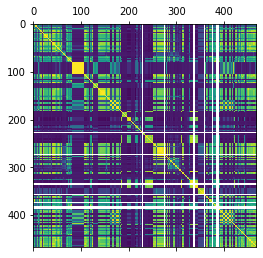

In [133]:
display(pivot.cov())

plt.matshow(pivot.corr())
plt.show()